# Designing error-robust digital SFQ controls for superconducting qubits
**Generating single flux quantum gates robust to leakage and frequency drift**

Boulder Opal enables you to [optimize](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs) and simulate quantum systems subjected to a wide range of pulsed controls. Single Flux Quantum (SFQ) logic provides a means to use digital control sequences consisting of trains of ultrafast flux pulses applied at rates comparable to the qubit frequency to manipulate qubits. This approach helps by circumventing issues that can arise from the room-temperature electronics used to generate microwave control pulses. However, the digitized nature of such controls opens up new challenges, such as susceptibility to leakage to other levels and frequency drifts. 

In this application note, we address these issues by designing the spacing between individual pulses, constructing sequences that are robust to leakage and frequency detuning. We will cover:

- Simulating SFQ digital logic for qubit manipulation
- Optimizing SFQ digital logic sequences to generate noise-robust quantum logic
- Validating performance by calculating quasi-static noise susceptibility





## Imports and initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())


def sequence_times_to_control_format(pulse_times, gate_duration):
    """
    Create control sequences describing a qubit's frequency omega,
    anharmonicity alpha, and SFQ Rabi rate for each PWC segment.

    The `pulse_times` define the start of each SFQ pulse,
    represented as square piecewise-constant segments.
    """
    segment_durations = pulse_times[1:] - pulse_times[0:-1]
    segment_durations = np.append(segment_durations, [gate_duration - pulse_times[-1]])

    control_durations = np.array([])
    # Binary switch to mark the segments where the square SFQ pulses are turned on.
    control_switch = np.array([])
    for segment_duration in segment_durations:
        # Encoding for pulse controls (1 during pulse duration, 0 otherwise).
        control_durations = np.append(
            control_durations, [pulse_duration, segment_duration - pulse_duration]
        )
        control_switch = np.append(control_switch, [1.0, 0.0])

    return {
        "omega": {"durations": np.array([gate_duration]), "values": np.array([omega])},
        "alpha": {"durations": np.array([gate_duration]), "values": np.array([alpha])},
        "pulse": {"durations": control_durations, "values": Omega_eff * control_switch},
    }


def evolve_states(initial_state, controls, sample_times):
    """
    Simulate the qubit state evolution for a given set of controls
    (as defined by sequence_times_to_control_format).
    """

    graph = bo.Graph()

    a = graph.annihilation_operator(3)
    adag = graph.creation_operator(3)
    n = graph.number_operator(3)

    # Hamiltonian terms.
    omega_signal = graph.pwc(**controls["omega"])
    alpha_signal = graph.pwc(**controls["alpha"])
    pulse_signal = graph.pwc(**controls["pulse"])
    hamiltonian = (
        omega_signal * n
        + alpha_signal / 2 * (n @ n - n)
        + pulse_signal * (a + adag) / 2
    )

    # Calculate the evolution unitaries.
    unitaries = graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=sample_times
    )

    evolved_states = unitaries @ initial_state[:, None]
    evolved_states.name = "evolved_states"

    graph_result = bo.execute_graph(graph, "evolved_states")

    return graph_result["output"]["evolved_states"]["value"]


# Data holders for SQF pulse sequences.
gate_durations = {}
pulse_times = {}
controls = {}

## Standard SFQ gate

In this section, we set up the standard $X$ gate based on a train of uniformly spaced SFQ pulses set apart by one Larmor period of the qubit ground state, described by the following Hamiltonian:

$$
H = (\omega + \Delta) a^\dagger a + \frac{\alpha}{2} (a^\dagger)^2 a^2 + \frac{\Omega (t)}{2}\left(a + a^\dagger\right), 
$$

where $a$ is the lowering operator, $\omega$ is the transmon frequency, $\Delta$ the frequency drift, $\alpha$ the anharmonicity, and $\Omega (t)$ the train of SFQ pulses. 

We'll now construct an $X$ gate of duration $d_{\text{gate}} = 10$ ns composed of $n=50$ SFQ pulses at times $t_k =k \frac{2\pi}{\omega}$, $k\in [0,1,... n-1]$, where each pulse perform a rotation of $\theta = \pi/50$.

As the SFQ pulse duration $d_{\text{pulse}}=10$ ps is short relative to the precession of the qubit, $d_{\text{pulse}}\ll\frac{2\pi}{\omega}$, one can conveniently model $\Omega (t)$ as a sequence of square pulses of equal amplitude $\Omega_\textrm{eff}=\theta/d_{\text{pulse}}$, as follows:
$$
\Omega (t) = \begin{cases}
\Omega_\textrm{eff} & \quad t \in (t_k, t_k + d_{\text{pulse}}) \\
0 & \quad \text{otherwise}
\end{cases}. 
$$

In the code below, we configure the "standard" $X$ gate and evaluate its state evolution using a three-level representation of the transmon.

Standard gate duration: 10.00 ns


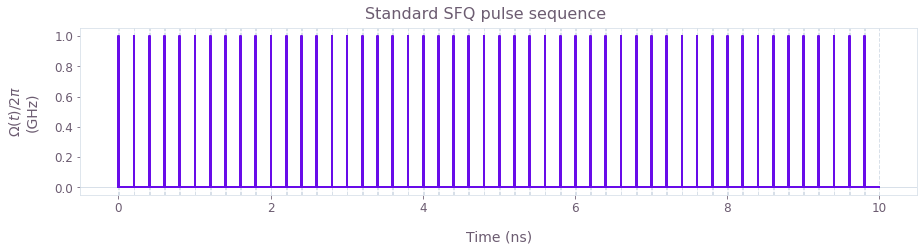

In [2]:
# System parameters.
alpha = -2 * np.pi * 400e6  # rad.Hz, transmon anharmonicity
omega = 2 * np.pi * 5e9  # rad.Hz, transmon frequency

# SFQ pulse parameters.
pulse_duration = 10e-12  # s
theta = np.pi / 50
Omega_eff = theta / pulse_duration

# Define the standard sequence of pulses (pulse rate is equal to transmon frequency).
pulse_count = 50
gate_durations["Standard"] = 10e-9  # s
pulse_times["Standard"] = np.arange(0, pulse_count) * 2 * np.pi / omega

controls["Standard"] = sequence_times_to_control_format(
    pulse_times["Standard"], gate_durations["Standard"]
)

# Plot the controls.
print(f"Standard gate duration: {gate_durations['Standard'] * 1e9:.2f} ns")
fig = plt.figure()
qv.plot_controls({"$\Omega(t)$": controls["Standard"]["pulse"]}, figure=fig)
fig.suptitle("Standard SFQ pulse sequence")
fig.set_size_inches(15, 3)

Plotted is the sequence of square SFQ pulses representing the standard $X$ gate. Here the spacing between the single flux pulses is set equal to the transmon frequency.   

In [3]:
initial_state = np.array([1.0, 0.0, 0.0])
sample_times = np.linspace(0, gate_durations["Standard"], 100)

state_evolution = evolve_states(initial_state, controls["Standard"], sample_times)

Your task (action_id="1827924") is queued.
Your task (action_id="1827924") has completed.


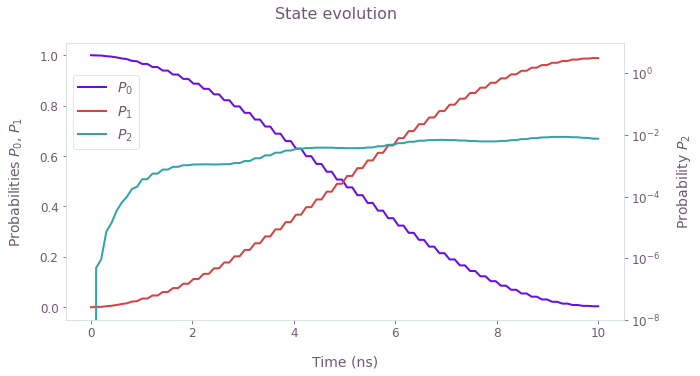

In [4]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.xlabel("Time (ns)")
plt.suptitle("State evolution")

probabilities = np.abs(state_evolution) ** 2

p0 = ax1.plot(sample_times * 1e9, probabilities[:, 0], label="$P_0$")
p1 = ax1.plot(sample_times * 1e9, probabilities[:, 1], label="$P_1$")
ax1.set_ylabel("Probabilities $P_0$, $P_1$")

ax2 = ax1.twinx()
p2 = ax2.semilogy(
    sample_times * 1e9,
    probabilities[:, 2],
    label="$P_2$",
    color=qv.QCTRL_STYLE_COLORS[2],
)

ax2.set_ylim([1e-8, 10])
ax2.set_ylabel("Probability $P_2$")

lgns = p0 + p1 + p2
lbs = [l.get_label() for l in lgns]
plt.legend(lgns, lbs, loc="center left", bbox_to_anchor=(0, 0.75))
plt.show()

Evolution of the populations of the three transmon levels during the application of the standard SFQ $X$ gate for the system initialized in the ground state. The populations for the qubit states $0$ and $1$ are shown in a linear scale (left axis) while the smaller population of state $2$ is shown in the log scale (right axis). Note that the leakage to the third state induces a significant operational infidelity ($I \sim 10^{-2}$).

## Optimized SFQ gate

In this section, we use Boulder Opal to generate an SFQ gate robust to both leakage and the drift in the qubit frequency. We will do this by allowing the application time of each pulse to vary. In experiments, the pulse time $t_k$ commonly changes discretely, in increments defined by a clock rate $\omega_c$. However, in the present example we'll make a simplifying assumption that the clock rate is significantly greater than the qubit frequency $\omega_c\gg\omega$. This allows the free precession periods between the pulses $\delta_t = t_{k+1}-t_k$ to vary continuously  $\delta_t\in (0,1)\frac{2\pi}{\omega}$.

Leakage suppression is achieved by including the third energy level into the Hamiltonian and by providing the ideal $X$ gate qubit unitary as the target operation to the optimizer. Robustness to drift is achieved by including a Hamiltonian noise term corresponding to the energy variation between the first two transmon levels.

In the cells below, we optimize an SFQ gate, plot its evolution and finally compare its performance against the standard gate from the previous section.

In [5]:
# Ideal X gate target unitary.
target = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])
projector = np.diag([1, 1, 0])

optimization_pulse_count = 160
optimization_count = 4

graph = bo.Graph()

a = graph.annihilation_operator(3)
adag = graph.creation_operator(3)
n = graph.number_operator(3)

# Binary switch to mark the segments where Omega_eff is turned on.
control_switch = np.tile([1.0, 0.0], optimization_pulse_count)

# For convenience, encode signal pwc values in units of phase by setting the
# effective duration of all pwc segments to 1; use number of segments as the effective gate duration.
segment_count = len(control_switch)  #  SFQ + free precession segments.

# omega component during the SFQ pulse.
pulse_omega_signal = graph.pwc_signal(
    values=omega * pulse_duration * control_switch, duration=segment_count
)
# alpha component during the SFQ pulse.
pulse_alpha_signal = graph.pwc_signal(
    values=alpha * pulse_duration * control_switch, duration=segment_count
)
# SFQ pulse.
Omega_eff_signal = graph.pwc_signal(
    values=Omega_eff * pulse_duration * control_switch, duration=segment_count
)
# Total pulse controls.
pulse_terms = (
    pulse_omega_signal * n
    + pulse_alpha_signal / 2 * (n @ n - n)
    + Omega_eff_signal * (a + adag) / 2
)

# Define free precession durations to be optimization variable.
free_durations = graph.optimization_variable(
    count=optimization_pulse_count,
    lower_bound=0.0,  #  Min free precession duration.
    upper_bound=2 * np.pi / omega,  # Max free precession duration.
    name="free_durations",
)
# Repeat elements to match the total number of segments, then switch off during the SFQ pulse segments.
free_durations = graph.repeat(free_durations, repeats=2, axis=0) * (
    1.0 - control_switch
)
# omega free precession terms.
free_omega_signal = graph.pwc_signal(
    values=omega * free_durations, duration=segment_count
)
# alpha free precession terms.
free_alpha_signal = graph.pwc_signal(
    values=alpha * free_durations, duration=segment_count
)
free_precession_terms = free_omega_signal * n + free_alpha_signal / 2 * (n @ n - n)

# Total hamiltonian term.
hamiltonian = pulse_terms + free_precession_terms

# Physical duration of the gate: pulse durations + free precession durations.
gate_duration = graph.sum(free_durations) + optimization_pulse_count * pulse_duration
gate_duration.name = "gate_duration"

detuning_noise_signal = graph.pwc_signal(
    values=free_omega_signal.values
    * 1.0
    / graph.sum(
        graph.abs(free_omega_signal.values)
    ),  # Normalized free precession phase values.
    duration=segment_count,
)
detuning_noise_term = detuning_noise_signal * np.array(
    [[-1.0, 0.0, 0.0], [0.0, 1.0, 0], [0.0, 0, 0.0]], dtype="complex128"
)

# Cost.
cost = graph.infidelity_pwc(
    hamiltonian=hamiltonian,
    target=graph.target(target @ projector),
    noise_operators=[detuning_noise_term],
    name="cost",
)
# Gate infidelity.
gate_infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian, target=graph.target(target), name="gate_infidelity"
)

result = bo.run_optimization(
    graph=graph,
    cost_node_name="cost",
    output_node_names=["free_durations", "gate_duration", "gate_infidelity"],
    optimization_count=optimization_count,
)

print(f"Optimization cost: {result['cost']:.3e}")
print(f"Operational infidelity: {result['output']['gate_infidelity']['value']:.3e}")

optimized_free_durations = result["output"]["free_durations"]["value"]

pulse_times["Q-CTRL"] = np.arange(
    0, optimization_pulse_count
) * pulse_duration + np.concatenate([[0], np.cumsum(optimized_free_durations[:-1])])

gate_durations["Q-CTRL"] = result["output"]["gate_duration"]["value"]

controls["Q-CTRL"] = sequence_times_to_control_format(
    pulse_times["Q-CTRL"], gate_durations["Q-CTRL"]
)

Your task (action_id="1827928") has started.
Your task (action_id="1827928") has completed.
Optimization cost: 3.173e-05
Operational infidelity: 3.086e-08


Q-CTRL gate duration: 27.09 ns


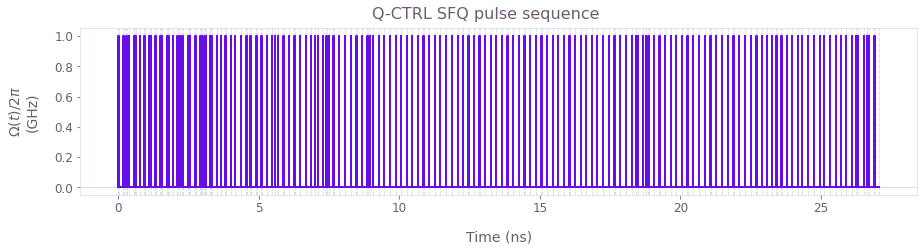

In [6]:
# Plot the controls.
print(f"Q-CTRL gate duration: {gate_durations['Q-CTRL'] * 1e9:.2f} ns")
fig = plt.figure()
fig.suptitle("Q-CTRL SFQ pulse sequence")
qv.plot_controls({"$\Omega(t)$": controls["Q-CTRL"]["pulse"]}, figure=fig)
fig.set_size_inches(15, 3)

Pulse sequence for the optimized SFQ $X$ gate. Note that using variable pulse spacing allows the optimizer to exploit more degrees of freedom in order to mitigate the effects of leakage and drift, as indicated by a more complex state evolution below. 

In [7]:
initial_state = np.array([1.0, 0.0, 0.0])
sample_times = np.linspace(0, gate_durations["Q-CTRL"], 100)

optimized_state_evolution = evolve_states(
    initial_state, controls["Q-CTRL"], sample_times
)

Your task (action_id="1827942") is queued.
Your task (action_id="1827942") has started.
Your task (action_id="1827942") has completed.


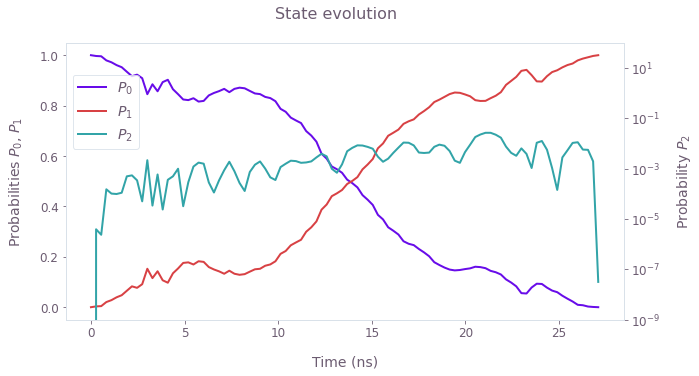

In [8]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.xlabel("Time (ns)")
plt.suptitle("State evolution")

probabilities = np.abs(optimized_state_evolution) ** 2

p0 = ax1.plot(sample_times * 1e9, probabilities[:, 0], label="$P_0$")
p1 = ax1.plot(sample_times * 1e9, probabilities[:, 1], label="$P_1$")
ax1.set_ylabel("Probabilities $P_0$, $P_1$")

ax2 = ax1.twinx()
p2 = ax2.semilogy(
    sample_times * 1e9,
    probabilities[:, 2],
    label="$P_2$",
    color=qv.QCTRL_STYLE_COLORS[2],
)

ax2.set_ylim([1e-9, 100])
ax2.set_ylabel("Probability $P_2$")

lgns = p0 + p1 + p2
lbs = [l.get_label() for l in lgns]
plt.legend(lgns, lbs, loc="center left", bbox_to_anchor=(0, 0.75))
plt.show()

Here is the evolution of the optimized SFQ X gate for the qubit initialized in the ground state. As in the plot for the standard gate, the population of the third level is shown in a log scale (right axis). Note that by the end of the gate, this population is minimized, allowing the operational infidelity ($I<10^{-7}$) to improve by 6 orders of magnitude as compared to the standard gate.

To demonstrate the gate robustness, in the cell below we calculate quasi-static noise susceptibility of the two controls as a function of qubit frequency detuning.

In [9]:
detunings = 2 * np.pi * np.linspace(-20, 20, 200) * 1e6
drift_infidelities = {}
for scheme in ["Standard", "Q-CTRL"]:
    scan_controls = controls[scheme]

    # Set up the graph for the quasi-static scan simulation.
    graph = bo.Graph()

    a = graph.annihilation_operator(3)
    adag = graph.creation_operator(3)
    n = graph.number_operator(3)

    omega_signal = graph.pwc(**scan_controls["omega"])
    alpha_signal = graph.pwc(**scan_controls["alpha"])
    pulse_signal = graph.pwc(**scan_controls["pulse"])
    detuning_signal = graph.pwc_signal(
        values=detunings[:, None], duration=gate_durations[scheme]
    )
    hamiltonian = (
        omega_signal * n
        + alpha_signal / 2 * (n @ n - n)
        + pulse_signal * (a + adag) / 2
        + detuning_signal * n
    )

    # Infidelities for detuning rates.
    infidelities = graph.infidelity_pwc(
        hamiltonian=hamiltonian, target=graph.target(target), name="infidelities"
    )

    # Calculate the graph and extract infidelities.
    graph_result = bo.execute_graph(graph, "infidelities")

    drift_infidelities[scheme] = graph_result["output"]["infidelities"]["value"]

Your task (action_id="1827956") has started.
Your task (action_id="1827956") has completed.
Your task (action_id="1827970") is queued.
Your task (action_id="1827970") has started.
Your task (action_id="1827970") has completed.


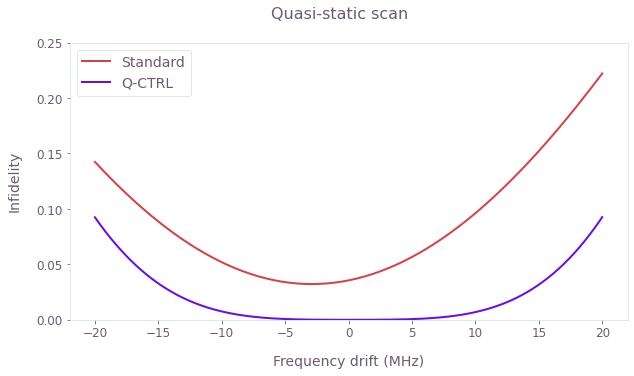

In [10]:
colors = {"Standard": qv.QCTRL_STYLE_COLORS[1], "Q-CTRL": qv.QCTRL_STYLE_COLORS[0]}

fig = plt.figure(figsize=(10, 5))
for scheme in ["Standard", "Q-CTRL"]:
    plt.plot(
        detunings / (2 * np.pi * 1e6),
        drift_infidelities[scheme],
        color=colors[scheme],
        label=scheme,
    )
fig.suptitle("Quasi-static scan")
plt.xlabel("Frequency drift (MHz)")
plt.ylabel("Infidelity")
plt.legend()
plt.ylim([0, 0.25])
plt.show()

Operational infidelity as a function of the drift in the qubit's frequency, allowing a comparison between the performances of the standard and the Boulder Opal gates. You can see the detrimental impact of leakage on the standard gate by its higher infidelity levels. In contrast, by minimizing leakage, the robust gate produces a much lower infidelity. Furthermore, due to the gate's robustness to frequency drift, this low infidelity level extends over a large range of detunings.